# Методы машинного обучения – Контрольная работа №2

# Нелинейная регрессия

Линейной регрессии может быть недостаточно для выявления взаимосвязи между признаками $X_{1},X_{2},...,X_{d}$ и откликом $Y$ в случае, когда эта взаимосвязь является нелинейной, поэтому приходится рассматривать более общий случай, когда

$$Y=f\left(\mathbf{X}\right)+\varepsilon=f\left(X_{1},X_{2},...,X_{d}\right)+\varepsilon,$$

где $\varepsilon$ – случайная ошибка, которая предполагается независимой от многомерной случайной величины $\mathbf{X}=\left(X_{1},X_{2},...,X_{d}\right)^{T}\in\mathbb{R}^{d}$, причем $\mathbb{E}\left[\varepsilon\right]=0$.

Импортируем необходимые библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

2024-04-25 21:11:40.333623: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 21:11:40.336497: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 21:11:40.382748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 21:11:41.300423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


При рассмотрении нелинейной регресии часто применяют градиентные методы.

### Моделирование градиентного спуска

Градиентный спуск — метод нахождения локального минимума или максимума функции с помощью движения вдоль градиента.

Изобразим график функции $y = (x-2.5)^2-1$:

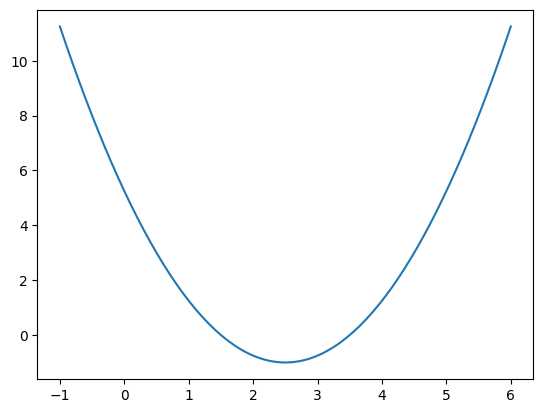

In [2]:
plot_x = np.linspace(-1., 6., 141)
plot_y = (plot_x-2.5)**2 - 1.
plt.plot(plot_x, plot_y);

Минимум этой функции достигается в точке $x=2.5$ и равен $-1$.

Для вычисления значений и производной функции $y = (x-2.5)^2-1$ будем использовать следующие функции:

In [3]:
def J(x_):
    return (x_-2.5)**2 - 1.

def dJ(x_):
    return 2*(x_-2.5)

Для моделирования градиентного спуска будем использовать функцию `gradient_descent()`, которая будет запоминать и возвращать историю итераций, для визуализации градиентного спуска будем использовать функцию `plot_history()`:

In [4]:
def gradient_descent(initial_x, eta, n_iters = 1e4, epsilon=1e-8):
    x_ = initial_x
    x_history = [initial_x]
    i_iter = 0

    while i_iter < n_iters:
        gradient = dJ(x_)
        last_x_ = x_
        x_ -= eta * gradient
        x_history.append(x_)

        if(abs(J(x_) - J(last_x_)) < epsilon):
            break
        i_iter += 1

    return x_history

def plot_history(plot_x, x_history):
    plt.plot(plot_x, J(plot_x))
    plt.plot(np.array(x_history), J(np.array(x_history)), color="r", marker='+')
    plt.text(1., 10., f'Кол-во шагов: {len(x_history)}', fontsize=14, color='r')

Проведем моделирование градиентного спуска с различной скоростью:

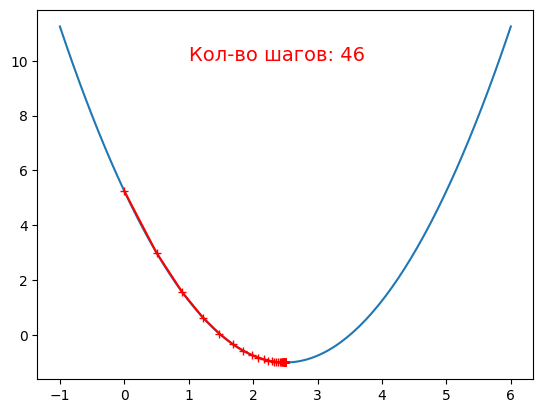

In [5]:
hist = gradient_descent(0., 0.1) # скорость 0.1
plot_history(plot_x, hist)

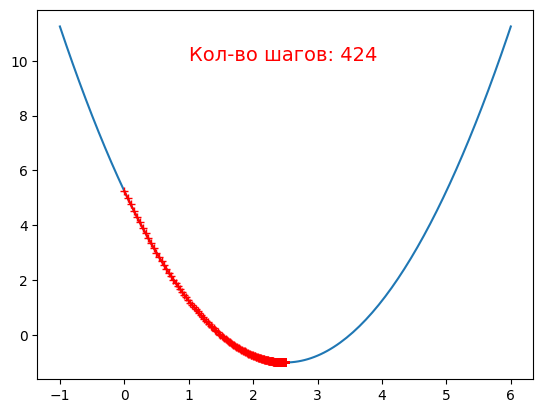

In [6]:
hist = gradient_descent(0., 0.01) # скорость 0.01
plot_history(plot_x, hist)

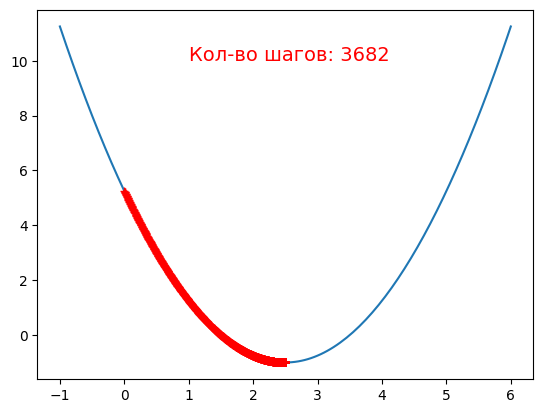

In [7]:
hist = gradient_descent(0., 0.001) # скорость 0.001
plot_history(plot_x, hist)

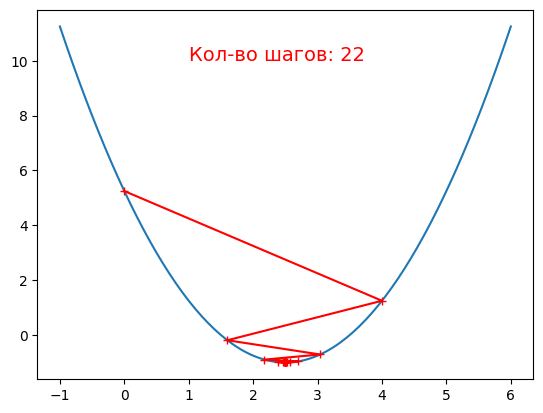

In [8]:
hist = gradient_descent(0., 0.8) # скорость 0.8
plot_history(plot_x, hist)

При дальнейшем увеличении скорости возникает ошибка, которую нужно обработать:

In [9]:
try:
    hist = gradient_descent(0., 1.1) # скорость 1.1
    plot_history(plot_x, hist)
except Exception as e:
    print(f"{type(e).__name__}: {e}")

OverflowError: (34, 'Numerical result out of range')


Поэтому ограничимся десятью итерациями:

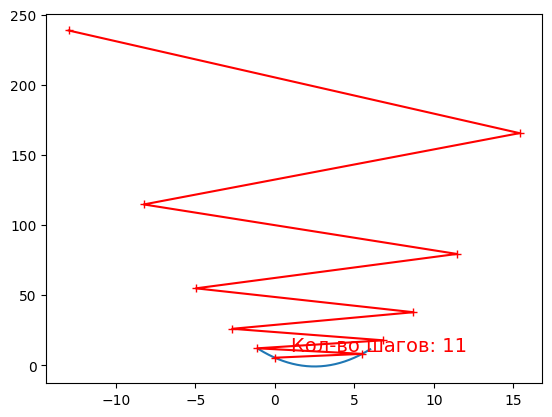

In [10]:
hist = gradient_descent(0., 1.1, n_iters=10)
plot_history(plot_x, hist)

Таким образом, при использовании градиентного спуска важную роль играет скорость (размер шага).

### Стохастический градиентный спуск

Стохастический градиентный спуск (stochastic gradient descent, SGD) − оптимизационный алгоритм, отличающийся от обычного градиентного спуска тем, что градиент оптимизируемой функции считается на каждом шаге не как сумма градиентов от каждого элемента выборки, а как градиент от одного, случайно выбранного элемента или некоторой подвыборки.

Рассмотрим следующий синтетический набор данных:

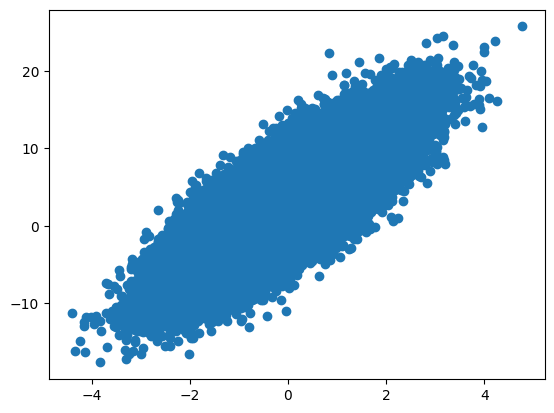

In [11]:
m = 100000 # количество точек в наборе

x = np.random.normal(size=m)
X = x.reshape(-1,1)           # преобразуем вектор в матрицу с одним столбцом
y = 4.*x + 3. + np.random.normal(0, 3, size=m)

plt.scatter(x, y);

Определим класс `RegressionSGD`, использующий стохастический градиентный спуск (с переменным шагом) при обучении модели:

In [12]:
class RegressionSGD:

    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        self._theta = None

    def fit(self, X_train, y_train, n_iters=50, t0=5, t1=50):
        assert X_train.shape[0] == y_train.shape[0], \
            "Размер X_train должен быть равен размеру y_train"
        assert n_iters >= 1

        def dJ_sgd(theta, X_b_i, y_i):
            return X_b_i * (X_b_i.dot(theta) - y_i) * 2.

        def sgd(X_b, y, initial_theta, n_iters=5, t0=5, t1=50):

            def learning_rate(t):
                return t0 / (t + t1)

            theta = initial_theta
            m = len(X_b)
            for i_iter in range(n_iters):
                indexes = np.random.permutation(m)
                X_b_new = X_b[indexes,:]
                y_new = y[indexes]
                for i in range(m):
                    gradient = dJ_sgd(theta, X_b_new[i], y_new[i])
                    theta = theta - learning_rate(i_iter * m + i) * gradient

            return theta

        X_b = np.hstack([np.ones((len(X_train), 1)), X_train])
        initial_theta = np.random.randn(X_b.shape[1])
        self._theta = sgd(X_b, y_train, initial_theta, n_iters, t0, t1)

        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]

        return self

    def predict(self, X_predict):
        assert self.intercept_ is not None and self.coef_ is not None, \
            "Нужно обучить модель перед использованием!"
        assert X_predict.shape[1] == len(self.coef_), \
            "Кол-во признаков в X_predict должно быть равно кол-ву признаков в X_train"

        X_b = np.hstack([np.ones((len(X_predict), 1)), X_predict])
        return X_b.dot(self._theta)

    def score(self, X_test, y_test):
        y_predict = self.predict(X_test)
        return r2_score(y_test, y_predict)

    def __repr__(self):
        return "RegressionSGD()"

Используем созданный класс для обучения модели линейной регрессии на сгенерированных ранее данных:

In [13]:
reg = RegressionSGD()
reg.fit(X, y, n_iters=2)
reg.coef_, reg.intercept_

(array([4.01905354]), 3.024264108285063)

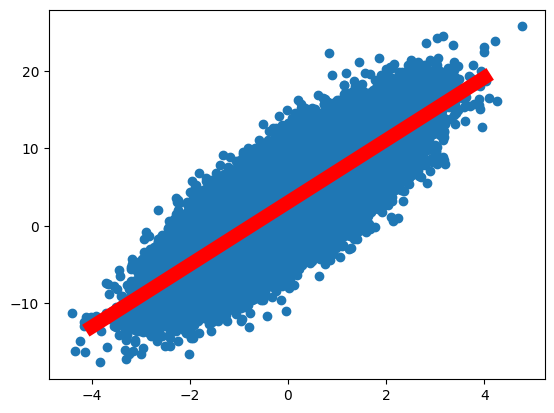

In [14]:
plt.scatter(x, y)
plot_x = np.linspace(-4, 4, 101)
plt.plot(plot_x, reg.predict(plot_x.reshape(-1,1)), c='r', lw=10);

### Полиномиальная регрессия

Полиномиальная регрессия – это форма регрессионного анализа, в которой взаимосвязь между независимой переменной $X$ и зависимой переменной $Y$ моделируется как полином $m$-й степени от $X$

$$Y=f\left(X,\mathbf{w}\right)=w_{0}+w_{1}X+w_{2}X^{2}+...+w_{m}X^{m}+\varepsilon$$

Полиномиальная регрессия может использоваться для решения задачи регрессии для нелинейных данных. В полиномиальной регрессии используется кривая линия, соответствующая полиному степени больше, чем 1. Например, пусть входные данные соответствуют зависимости $y=0.5 x^2+x+2$ (с нормальным шумом):

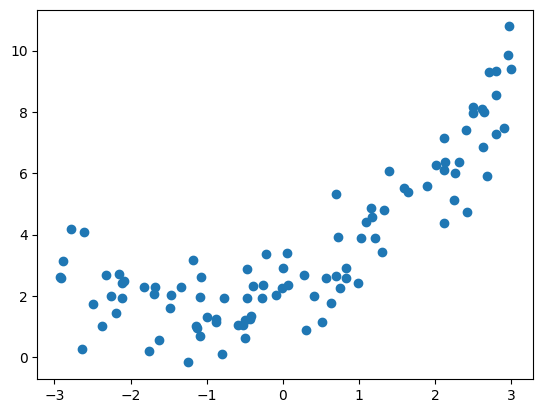

In [15]:
x = np.random.uniform(-3, 3, size=100) # вектор
X = x.reshape(-1, 1)                   # матрица с одним стобцом
y = 0.5 * x**2 + x + 2 + np.random.normal(0, 1, size=100)

plt.scatter(x, y);

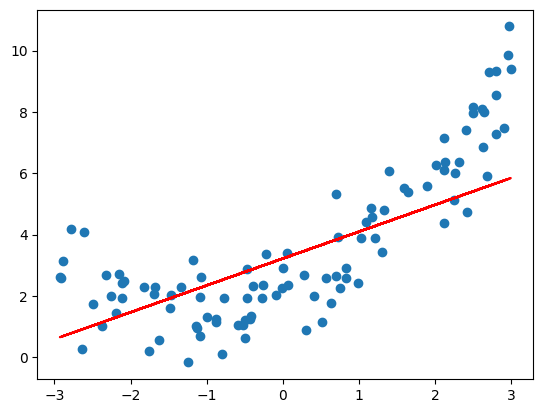

In [16]:
reg = RegressionSGD()
reg.fit(X, y, n_iters=2)
y_predict = reg.predict(X)

plt.scatter(x, y)
plt.plot(x, y_predict, color='r');

Подготовим для модели регрессии входные данные с двумя признаками – линейной и квадратичной зависимостью от независимой переменной:

In [17]:
X.shape

(100, 1)

In [18]:
X2 = np.hstack([X, X**2]) # соединение массивов по горизонтали
X2.shape

(100, 2)

Применим к построенным данным модель регрессии на основе SGD и нарисуем набор данных и линию регрессии (функция `np.argsort` возвращает индексы элементов в отсортированном массиве):

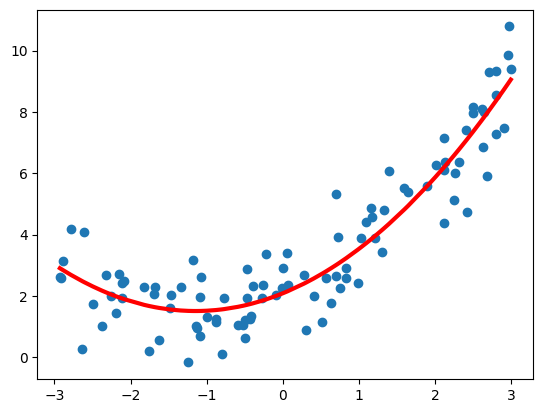

In [19]:
reg2 = RegressionSGD()
reg2.fit(X2, y, n_iters=2000)
y_predict2 = reg2.predict(X2)

plt.scatter(x, y)
plt.plot(np.sort(x), y_predict2[np.argsort(x)], c='r', lw=3);

Если не использовать функции `sort()` и `argsort()`, то график выглядит так:

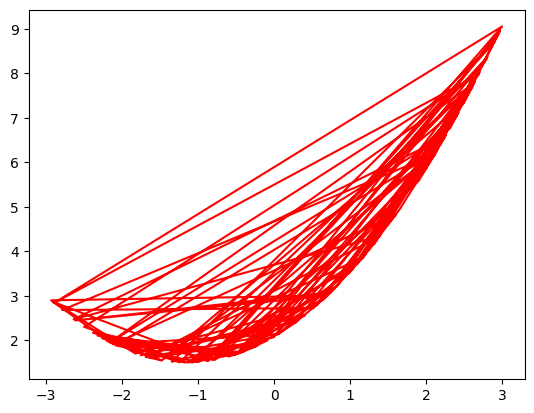

In [20]:
plt.plot(x, y_predict2, c='r');

Определенные при помощи стохастического градиентного спуска коэффициенты регрессии и смещение близки к значениям, использованным при генерации данных:

In [21]:
reg2.coef_, reg2.intercept_

(array([1.00850825, 0.43971407]), 2.083802434092929)

Альтернативный способ построения наборов данных, содержащих полиномиальные зависимости от исходных данных, состоит в применении класса `PolynomialFeatures` из библиотеки `scikit-learn`:

In [22]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=4)
poly.fit(X)
X2s = poly.transform(X)
X2s

array([[ 1.00000000e+00, -1.17850628e+00,  1.38887705e+00,
        -1.63680033e+00,  1.92897946e+00],
       [ 1.00000000e+00, -2.25746016e+00,  5.09612636e+00,
        -1.15043022e+01,  2.59705038e+01],
       [ 1.00000000e+00, -4.74220194e-01,  2.24884792e-01,
        -1.06644910e-01,  5.05731699e-02],
       [ 1.00000000e+00, -1.07399185e+00,  1.15345849e+00,
        -1.23880502e+00,  1.33046649e+00],
       [ 1.00000000e+00,  8.34603365e-01,  6.96562778e-01,
         5.81353638e-01,  4.85199703e-01],
       [ 1.00000000e+00,  2.80619868e+00,  7.87475105e+00,
         2.20981160e+01,  6.20117040e+01],
       [ 1.00000000e+00, -8.73086196e-01,  7.62279505e-01,
        -6.65535713e-01,  5.81070044e-01],
       [ 1.00000000e+00, -2.90812639e+00,  8.45719910e+00,
        -2.45946039e+01,  7.15242166e+01],
       [ 1.00000000e+00, -2.11201666e+00,  4.46061437e+00,
        -9.42089186e+00,  1.98970805e+01],
       [ 1.00000000e+00,  1.59926728e+00,  2.55765584e+00,
         4.09037530e+00

### Стандартизация и масштабирование признаков

__Стандартизацией__ случайной величины $X$ называют ее линейное преобразование, приводящее к случайной величине с математическим ожиданием $0$ и стандартным отклонением $1$:

$\tilde{X}=\frac{X-\mathbb{E}\left[X\right]}{\sqrt{\mathbb{V}\left[X\right]}},$

где $\mathbb{E}$ – операция вычисления математического ожидания, $\mathbb{V}$ – операция вычисления дисперсии.

Стандартизация набора данных является существенным условием для применения многих алгоритмов машинного обучения, а именно, алгоритмы дают приемлемый результат, только если отдельные признаки распределены примерно как стандартные нормальные величины (с нулевым матожиданием и единичной дисперсией).

Для стандартизации признаков набора данных может быть использована код:

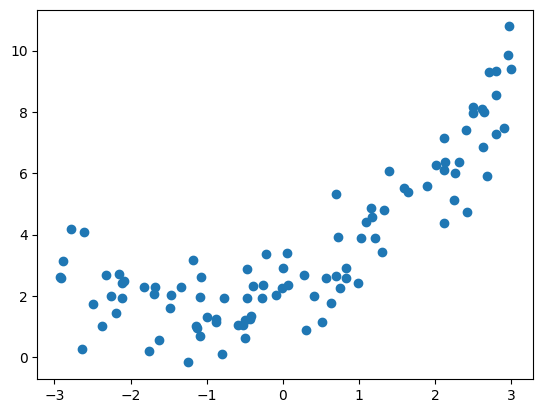

In [23]:
plt.scatter(x, y);

(7.549516567451065e-17, 1.0, -4.440892098500626e-16, 1.0)

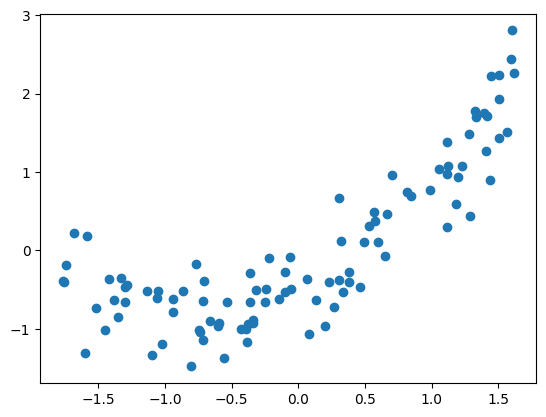

In [24]:
x_s, y_s = (x - np.mean(x))/np.std(x), (y - np.mean(y))/np.std(y)
plt.scatter(x_s, y_s)
np.mean(x_s), np.std(x_s), np.mean(y_s), np.std(y_s)

Альтернативным вариантом является масштабирование признака между заданным минимальным и максимальным значениями, скажем, между $[0, 1]$. Этот эффект может быть достигнут при помощи кода:

(0.0, 1.0, 0.0, 1.0)

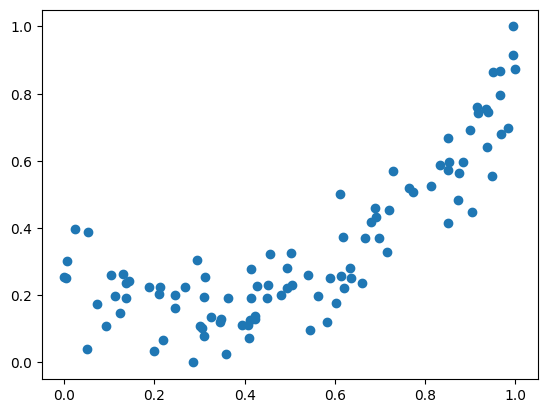

In [25]:
x_m = (x - np.min(x))/(np.max(x) - np.min(x))
y_m = (y - np.min(y))/(np.max(y) - np.min(y))
plt.scatter(x_m, y_m)
np.min(x_m), np.max(x_m), np.min(y_m), np.max(y_m)

### Выбросы

Выбросами (outliers) называются записи (строки) с характеристиками, которые существенно отличаются от характеристик остальных записей набора данных.

Чтобы убрать выбросы, можно посчитать стандартизованную оценку (Z-score) для каждого признака и убрать записи, содержащие атрибуты с ненормально высоким или низким Z-score (например, $Z>3$ или $Z<-3$). Для нормального распределения вероятность отклонения случайной величины от своего математического ожидания более чем на три стандартных отклонения практически равна нулю (правило трех сигм).

Следующий код показывает результаты стандартизации стоблцов с данными. Отсутствующие значения (NaN) не затрагиваются процессом стандартизации.

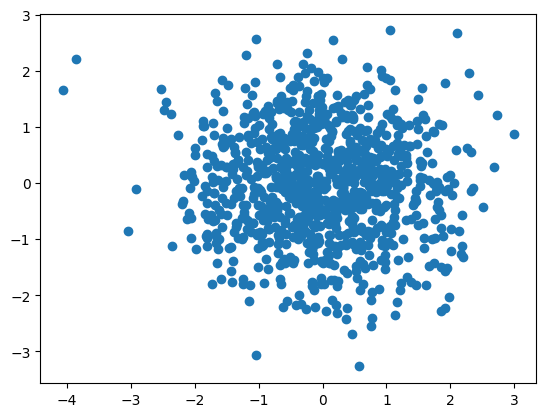

In [26]:
x_out = np.random.normal(size=2000).reshape(1000,2)
plt.scatter(x_out[:,0], x_out[:,1]);

In [27]:
z_score = 3.
print('Число точек до удаления выбросов = %d' % (x_out.shape[0]))
x2_out = x_out[((x_out >= -z_score).sum(axis=1)==2) & ((x_out <= z_score).sum(axis=1)==2),:] # NB .loc
print('Число точек после удаления выбросов = %d' % (x2_out.shape[0]))

Число точек до удаления выбросов = 1000
Число точек после удаления выбросов = 995


### Полиномиальная регрессия при помощи TensorFlow

Полиномиальная регрессия также может быть реализована при помощи `TensorFlow` и `keras`.

Математически __искусственная нейронная сеть__ (прямого распространения) представляет собой направленный граф с нейронами в качестве вершин и связями между нейронами в виде ребер, причем вход для каждого нейрона является функцией взвешенной суммы выходов всех нейронов, связанных с ним входящими ребрами. Тогда выход нейронной сети равен

$$\mathbf{f\left(\mathbf{x};\theta\right)=\psi_{d}\left(...\psi_{2}\left(\psi_{1}\left(\mathbf{x}\right)\right)\right),\,\psi_{i}\left(\mathbf{x}\right)=\sigma_{i}\left(\mathbf{w^{\left(i\right)}\,x+b^{\left(i\right)}}\right)}$$

Здесь каждый слой сети представляется __функцией активации__ $\mathbf{\sigma_{i}}$ с аргументом в виде взвешенной суммы входных данных $\mathbf{x}$ с __весами__ $\mathbf{w^{\left(i\right)}}$ и __смещениями__ $\mathbf{b^{\left(i\right)}}$. Число слоев $\mathbf{d}$ называется __глубиной__ нейронной сети и количество нейронов в слое представляет собой __ширину__ этого слоя.

Целью глубокого обучения является определение набора параметров сети $\mathbf{\theta=\left\{ w^{\left(i\right)},b^{\left(i\right)}\right\} _{i=1}^{d}}$, который минимизирует __функцию потерь__ $\mathbf{\mathcal{L}(\theta)}$, определяющую качество модели при заданном наборе параметров $\theta$.

Создадим простейшую нейронную сеть с одним слоем из одного нейрона и двумя входными нейронами:

In [28]:
reg2_model = tf.keras.Sequential([
    tf.keras.Input(shape=(2,)),
    tf.keras.layers.Dense(units=1)
])

В такой нейронной сети будет всего три обучаемых параметра (два веса и смещение):

In [29]:
reg2_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

При компиляции модели в обязательном порядке указывается функция потерь (`loss`), также может быть выбран оптимизатор с параметрами (`optimizer`), метрики для оценки обучения (`metrics`) и некоторые другие другие параметры. В качестве функции потерь и/или метрики могут быть, в частности,  выбраны среднеквадратичная ошибка (MSE) и средняя абсолютная ошибка (MAE). Коэффициента детерминации $R^2$ среди стандартных функций потерь и метрик нет, но он легко может быть вычислен непосредственно по показателю MSE и общей дисперсии целевой переменной.

In [30]:
reg2_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Обучаем нейронную сеть на полиномиальных зависимостях:

In [31]:
history = reg2_model.fit(
    X2, y,
    epochs=100,
    # уровень выводимой информации
    verbose=1,
    # проверка (валидация) на 30% обучающих данных
    validation_split = 0.3)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.4520 - val_loss: 3.0052
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7500 - val_loss: 2.4701
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2600 - val_loss: 2.0222
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1605 - val_loss: 1.7568
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8040 - val_loss: 1.4545
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5416 - val_loss: 1.0864
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1283 - val_loss: 0.9245
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9520 - val_loss: 0.8802
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9545 - val_loss: 0.8559
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9126 - val_loss: 0.7628
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8541 - val_loss: 0.7241
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7518 - val_loss: 0.81

Метод `fit` возвращает объект `history`, в котором для задачи регрессии обычно есть ключи `'loss'` и `'val_loss'`. Можно визуализировать историю обучения при помощи следующей функции:

In [32]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylim([0, max(history.history['loss'])*0.5])
  plt.title('Функция потерь при обучении модели')
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Функция потерь')
  plt.legend(['Обучающая выборка', 'Тестовая выборка'], loc='upper right')
  plt.grid(True)

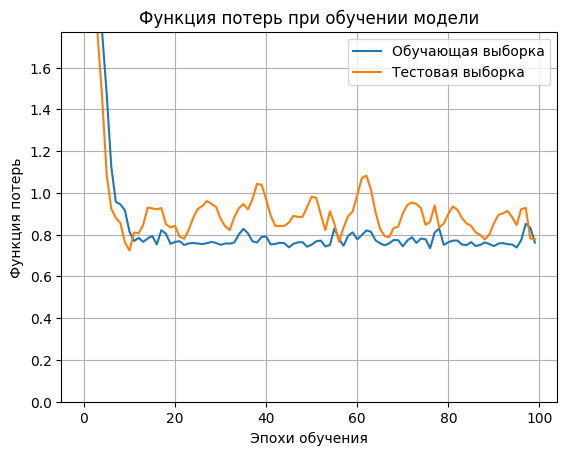

In [33]:
plot_loss(history)

При помощи обученной модели можно выполнить прогноз:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


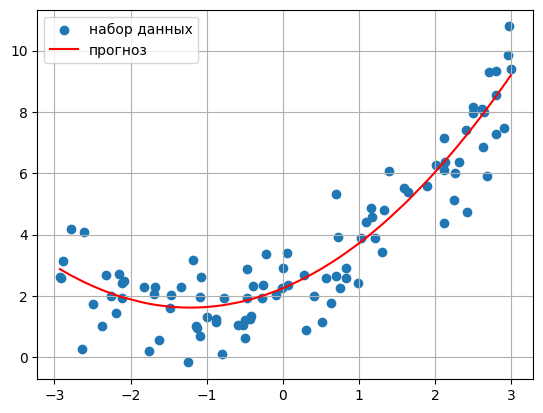

In [34]:
y_predict_reg2 = reg2_model.predict(X2)

plt.scatter(x, y, label='набор данных')
plt.plot(np.sort(x), y_predict_reg2[np.argsort(x)], color='r', label='прогноз')
plt.legend(loc='upper left')
plt.grid();

### Нелинейная парная регрессия при помощи TensorFlow

Универсальная теорема аппроксимации утверждает, что любую непрерывную функцию можно с любой степенью точности аппроксимировать нейронной сетью с одним скрытым слоем с функцией активации сигмоида $\sigma\left(\mathrm{x}\right)=\frac{1}{1+\exp\left(-\mathrm{x}\right)}$.

Построим и обучим нейронную сеть такого типа для рассматриваемого набора данных:

In [35]:
uni_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    tf.keras.layers.Dense(units=512, activation='sigmoid'),
    tf.keras.layers.Dense(units=1)
])

In [36]:
uni_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 512)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
uni_model.compile(loss='mse',
                  optimizer=tf.optimizers.Adam(learning_rate=0.1),
                  metrics=['mae'])

In [38]:
X.shape

(100, 1)

In [39]:
history = uni_model.fit(
    X, y,
    epochs=100,
    # уровень выводимой информации
    verbose=1,
    # проверка (валидация) на 20% обучающих данных
    validation_split = 0.2)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 195.0494 - mae: 10.2469 - val_loss: 92.2834 - val_mae: 9.4385
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 161.0700 - mae: 12.1371 - val_loss: 86.0724 - val_mae: 9.0526
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 49.2125 - mae: 6.1844 - val_loss: 83.7075 - val_mae: 8.4020
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 91.5243 - mae: 8.6376 - val_loss: 43.4543 - val_mae: 6.0875
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 26.1476 - mae: 4.4525 - val_loss: 25.8345 - val_mae: 4.1875
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 33.4646 - mae: 4.9219 - val_loss: 42.1716 - val_mae: 5.7193
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 29.3797 - mae: 4.7391 - val_loss: 3.9786 - val_mae: 1.6374
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4957 - mae: 1.7267 - val_loss: 18.3927 - val_mae: 3.9126
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

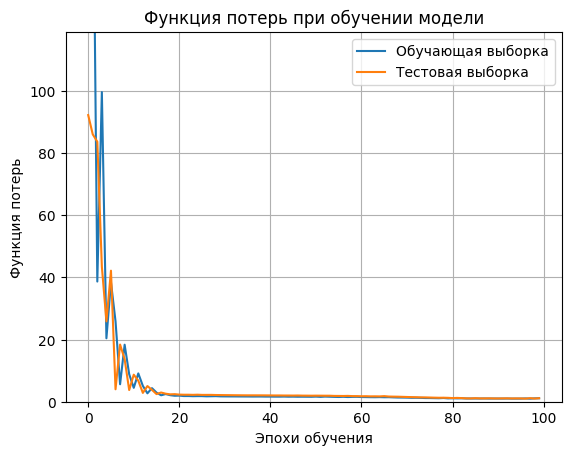

In [40]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


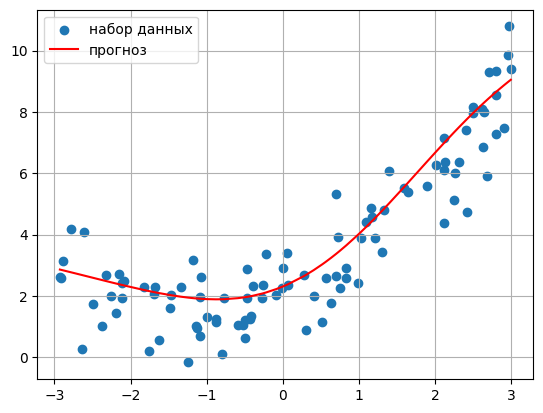

In [41]:
y_predict_uni = uni_model.predict(X)

plt.scatter(x, y, label='набор данных')
plt.plot(np.sort(x), y_predict_uni[np.argsort(x)], color='r', label='прогноз')
plt.legend(loc='upper left')
plt.grid();

### Нелинейная множественная регрессия при помощи TensorFlow

При помощи нейронных сетей с нелинейными функциями активации нейронов можно успешно решать задачи нелинейной регрессии.

Загрузим из TesorFlow Datasets набор `howell` с демографическими данными жителей Калахари:

In [42]:
ds = tfds.load("howell", split='train')
df = tfds.as_dataframe(ds)
df

2024-04-25 21:11:58.681094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,age,height,male,weight
0,20.000000,154.899994,1,38.200001
1,21.000000,155.574997,0,45.529297
2,21.000000,146.050003,0,44.763859
3,21.000000,163.830002,1,46.776676
4,18.000000,149.225006,0,42.127357
5,5.000000,101.599998,0,15.337079
6,25.000000,147.320007,0,48.959587
7,38.000000,147.320007,0,51.255898
8,1.000000,60.452000,1,5.669900
9,29.000000,144.779999,0,38.045029


Изучим зависимость возраста от роста и веса:

In [43]:
X = np.array(df[['height','weight']])
y = np.array(df[['age']]).reshape(-1)

In [44]:
X.shape, y.shape

((544, 2), (544,))

### Визуализация трехмерных данных

Для построения 3d графиков необходимо импортировать необходимые модули:

In [45]:
from mpl_toolkits import mplot3d
# или from mpl_toolkits.mplot3d import Axes3D

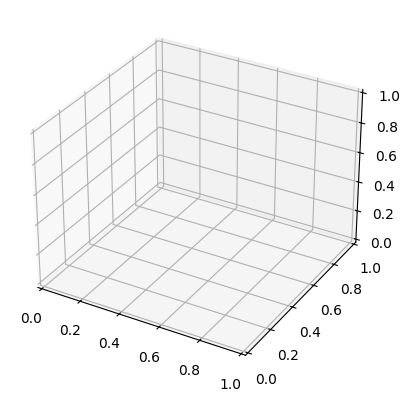

In [46]:
fig = plt.figure()
ax = plt.axes(projection='3d') # или ax = fig.add_subplot(111, projection='3d')

Для построения точечного графика можно использовать функцию `scatter()`, которой передаются три параметра для координат точек по осям X, Y и Z.

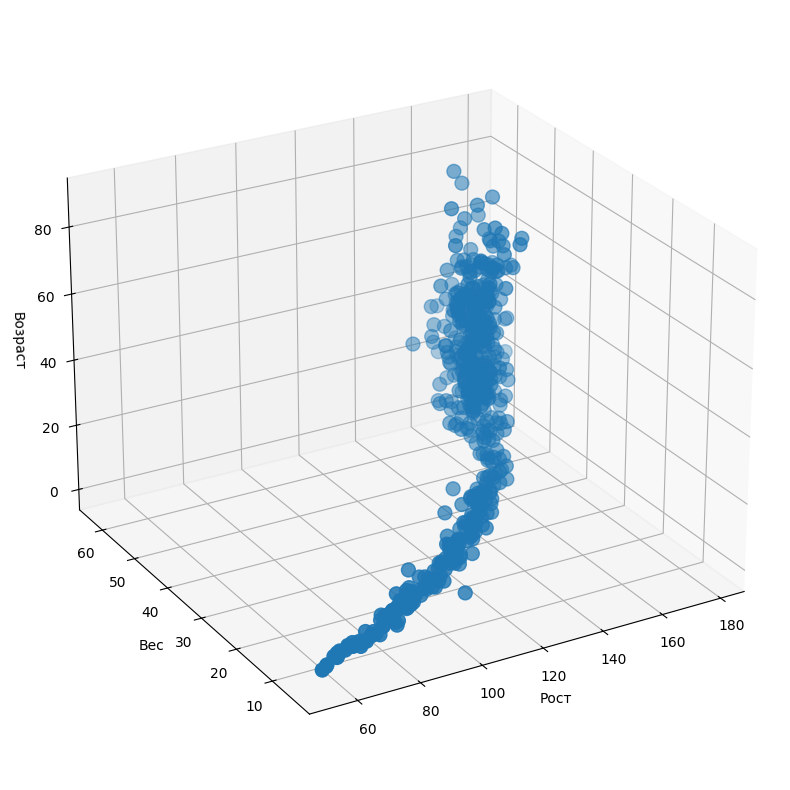

In [47]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')

xs = X[:,0]
ys = X[:,1]
zs = y

ax.scatter( xs, ys, zs, s=100 )
ax.set_xlabel('Рост')
ax.set_ylabel('Вес')
ax.set_zlabel('Возраст')
ax.view_init( azim=-120, elev=25 )

### Глубокая нейронная сеть для задачи регрессии

Используем слой нормализации, адаптированный к обоим независимым признакам:

In [48]:
feature_normalizer = tf.keras.layers.Normalization(axis=None,input_shape=(2,))
feature_normalizer.adapt(X)

/home/gmatiukhin/Study/year3/ml-methods/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Создадим нейронную сеть со слоем нормализации, четырьмя скрытыми плотными слоями с 64 нейронами и функцией активации ReLu и выходным слоем из одного нейрона:

In [49]:
large_model = tf.keras.Sequential([
    feature_normalizer,
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

large_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,740 (49.77 KB)

 Trainable params: 12,737 (49.75 KB)

 Non-trainable params: 3 (16.00 B)

Скомпилируем модель, используя в качестве функции потерь  среднеквадратичную ошибку MSE с оптимизатором по умолчанию (RmsProp):

In [50]:
large_model.compile(loss='mse')

Обучим модель на наборе данных из двух признаков:

In [51]:
history = large_model.fit(
    X, y,
    epochs=100,
    # уровень выводимой информации
    verbose=1,
    # проверка (валидация) на 30% обучающих данных
    validation_split = 0.3)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1297.5134 - val_loss: 1117.3909
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1306.4004 - val_loss: 879.3789
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 903.9586 - val_loss: 540.1088
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 549.6630 - val_loss: 366.7239
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 385.5807 - val_loss: 331.2133
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 345.6284 - val_loss: 302.5322
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 323.3306 - val_loss: 271.6499
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 274.5341 - val_loss: 251.8014
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 245.1263 - val_loss: 229.5044
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 238.9796 - val_loss: 220.6487
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 246.3776 - val_loss: 216.9624
Epoch 12/100
12

Кривые обучения в зависимости от эпохи обучения выглядят так:

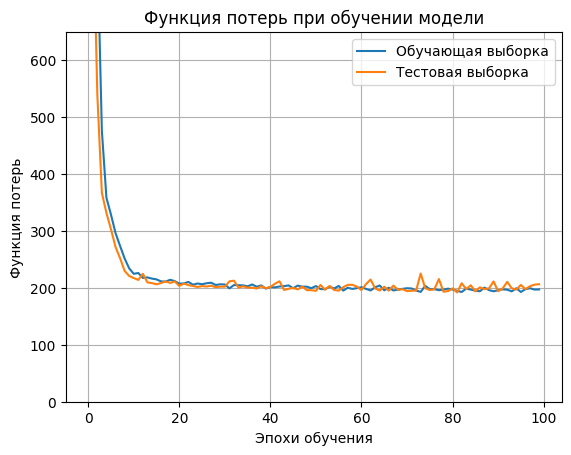

In [52]:
plot_loss(history)

Для визуализации прогнозируемых множественной регрессией значений воспользуемся функцией `plot_surface`. Потребуются определенные усилия по подготовке данных для `plot_surface`:

In [53]:
n_plot = 51

x_plot = np.linspace(np.min(xs), np.max(xs), n_plot)
y_plot = np.linspace(np.min(ys), np.max(ys), n_plot)

In [54]:
x_mesh, y_mesh = np.meshgrid(x_plot, y_plot)
x_mesh.shape, y_mesh.shape

((51, 51), (51, 51))

In [55]:
x_plot2 = np.reshape(x_mesh, [n_plot**2,1])
y_plot2 = np.reshape(y_mesh, [n_plot**2,1])
xy_2 = np.hstack([x_plot2, y_plot2])
xy_2.shape

(2601, 2)

Теперь выполним прогнозирование при помощи обученной ранее модели, после чего вернемся к форме данных 51 на 51:

In [56]:
z = large_model.predict(xy_2)
z.shape

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(2601, 1)

In [57]:
z_mesh = z.reshape((n_plot, n_plot))
z_mesh.shape

(51, 51)

Функция `plot_surface` имеет большое число параметров, в частности:

* X, Y, Z : 2D массивы – данные для построения поверхности.
* rstride, cstride : int – параметры определяют величину шага, с которым будут браться элементы строки/столбца из переданных массивов.
* cmap: Colormap – цветовая карта для элементов поверхности.


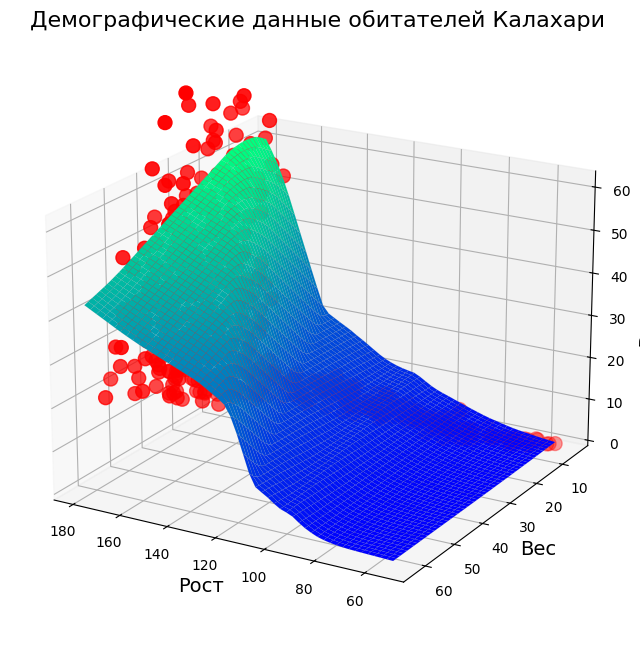

In [58]:
from matplotlib import cm

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_mesh, y_mesh, z_mesh, \
       rstride=1, cstride=1, linewidth=0.05, cmap=cm.winter, antialiased=True, \
       edgecolors='gray')
ax.scatter( xs, ys, zs, s=100, c='r' )

ax.set_xlabel('Рост', fontsize=14)
ax.set_ylabel('Вес', fontsize=14)
ax.set_zlabel('Возраст', fontsize=14)
ax.set_title('Демографические данные обитателей Калахари', fontsize=16)

ax.set_zlim(0., z_mesh.max())
ax.view_init(elev = 20, azim = 120)

__Кривые обучения__ — это графическое представление зависимости меры (показателя) качества обучения (по вертикальной оси) от определенного показателя модели обучения (по горизонтальной оси). Будем визуализировать в качестве качества модели показатели RMSE для части обучающей выборки и тестовой выборки в зависимости от количества точек в обучающей выборке.

Для разбиения на обучающую и тестовую выборки можно использовать функцию `train_test_split`:

In [59]:
def train_test_split(X, y, test_ratio=0.2, seed=None):
    """возвращает X_train, X_test, y_train, y_test"""
    assert X.shape[0] == y.shape[0], \
        "Размер X должен быть равен размеру y"
    assert 0.0 <= test_ratio <= 1.0, \
        "Неверное значение test_ratio"

    if seed:
        np.random.seed(seed)

    shuffled_indexes = np.random.permutation(len(X))

    test_size = int(len(X) * test_ratio)
    test_indexes = shuffled_indexes[:test_size]
    train_indexes = shuffled_indexes[test_size:]

    X_train = X[train_indexes]
    y_train = y[train_indexes]

    X_test = X[test_indexes]
    y_test = y[test_indexes]

    return X_train, X_test, y_train, y_test

Разобьем массивы данных `X` и `y` на обучающие и тестовые данные:

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((381, 2), (163, 2), (381,), (163,))

Будем использовать для визуализации показатель RMSE:

In [61]:
def my_rmse(y_test, y_predict):
    return np.sqrt(np.sum((y_predict - y_test)**2) / len(y_test))

Всего в обучающей выборке 381 точка, начнем с 11 точек и будем прибавлять по 10 точек на каждом шаге цикла:

In [62]:
train_score = []
test_score = []
for i in range(11, 382, 10):
    large_model = tf.keras.Sequential([
        feature_normalizer,
#        tf.keras.layers.Dense(units=64, activation='relu'),
#        tf.keras.layers.Dense(units=64, activation='relu'),
#        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])
    large_model.compile(loss='mse')
    large_model.fit(X_train[:i], y_train[:i], epochs=50, verbose=0)

    y_train_predict = large_model.predict(X_train[:i])
    train_score.append(my_rmse(y_train[:i], y_train_predict))

    y_test_predict = large_model.predict(X_test)
    test_score.append(my_rmse(y_test, y_test_predict))
    print('-->', i, ' done')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
--> 11  done


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
--> 21  done
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
--> 31  done
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
--> 41  done
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step
--> 51  done
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
--> 61  done
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
--> 71  done
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
--> 81  done
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
--> 91  done
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
--> 101  done
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
--> 111  done
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
--> 121  done
5/5 ━━━━

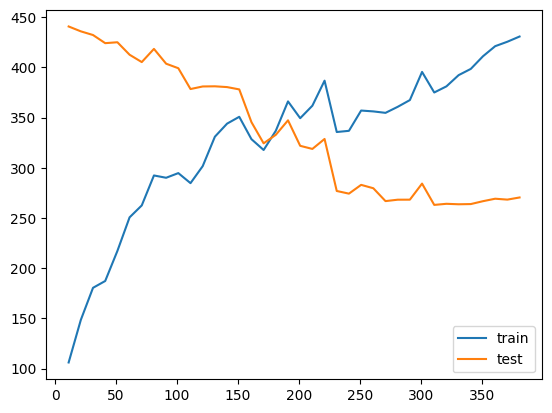

In [63]:
plt.plot([i for i in range(11, len(X_train)+1, 10)],
                               train_score, label="train")
plt.plot([i for i in range(11, len(X_train)+1, 10)],
                               test_score, label="test")
plt.legend();

#### Задание (10 баллов)

Для закрепленного за Вами варианта контрольной работы:

1.	Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимый признак и зависимый признак (отклик). Оставьте в наборе признаки, принимающие числовые значения.
2.	Удалите из набора точки с выбросами при помощи стандартизованной оценки (Z-score) таким образом, чтобы точки с выбросами составляли от 5% до 10% всех точек набора данных. Визуализируйте точки исходного набора данных на плоскости в виде диаграммы рассеяния (ось X – независимый признак, ось Y – зависимый признак), показывая оставленные в наборе точки и удаленные точки разными цветами, подписывая оси и рисунок и создавая легенду.
3.	Выполните стандартизацию независимого признака и масштабирование на интервал [-1, 1] зависимого признака. Решите задачи линейной регрессии и полиномиальной регрессии для степени полинома, указанной в индивидуальном задании, при помощи нейронных сетей с одним нейроном и оцените качество полученных моделей по показателю, указанному в индивидуальном задании. Отследите обучение нейронных сетей, изменяя, при необходимости, гиперпараметры (функцию потерь, оптимизатор, шаг обучения и т.п.) или применяя регуляризацию.
4.	Постройте кривые обучения для построенных нейронных сетей с зависимостью от количества эпох. На визуализации создайте легенду.
5.	Визуализируйте точки набора данных на плоскости в виде диаграммы рассеяния (ось X – независимый признак, ось Y – зависимый признак), а также линии линейной и полиномиальной регрессий (другими цветами), подписывая оси и рисунок и создавая легенду.
6.	Определите в исходном наборе данных признак (отличный от независимого и зависимого признаков), принимающий непрерывные значения и имеющий свойства, указанные в индивидуальном задании.
7.	Стандартизуйте этот признак и визуализируйте его в соответствии с индивидуальным заданием.
8.	Сформируйте набор входных данных из двух стандартизованных признаков набора данных (независимый признак и определенный признак), постройте нейронную сеть (нелинейный регресор) с количеством скрытых слоев, количеством нейронов и функцией активации, указанными в индивидуальном задании, и одним нейроном в выходном слое и обучите ее на наборе данных из двух признаков и отклика. Отследите обучение нейронной сети, изменяя, при необходимости, гиперпараметры (функцию потерь, оптимизатор, шаг обучения и т.п.) или применяя регуляризацию.
9.	Визуализируйте набор данных в виде диаграммы рассеяния и прогноз нейронной сети в виде поверхности в трехмерном пространстве, подписывая оси и рисунок.
10.	Разбейте набор данных из двух признаков и отклика на обучающую и тестовую выборки и постройте кривые обучения для заданного показателя качества в зависимости от количества точек в обучающей выборке, подписывая оси и рисунок и создавая легенду.



